# Import All Libraries 

In [41]:
import pandas as pd
import nltk
import spacy
import swifter 
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from gensim import corpora
from gensim.corpora import Dictionary

from gensim.models import LdaModel
from gensim.parsing.preprocessing import preprocess_string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words


# Load the dataset


In [2]:
df = pd.read_csv('../data/raw_analyst_ratings.csv')


# 1. Sentiment Analysis

In [6]:
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\habteyes.asfaw\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Apply VADER Sentiment Analysis


In [7]:
df['sentiment'] = df['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))


# 2. Text Preprocessing for Topic Modeling

In [29]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')).union(sklearn_stop_words)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\habteyes.asfaw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
def preprocess_text(text):
    # Lowercase and tokenization with stopword removal
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.lemma_ not in stop_words and not token.is_punct and not token.is_space]


In [31]:
df['tokens'] = df['headline'].swifter.apply(preprocess_text)


Pandas Apply: 100%|██████████| 1407328/1407328 [9:36:31<00:00, 40.68it/s]      


# 3. Topic Modeling using LDA


In [35]:
dictionary = Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

### Build LDA Model


In [37]:
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=5, chunksize=1000, random_state=100)


### Display the topics


In [38]:
topics = lda_model.print_topics(num_words=5)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

Topic 0: 0.028*"market" + 0.028*"update" + 0.027*"share" + 0.025*"etfs" + 0.021*"retail"
Topic 1: 0.019*"'s" + 0.017*"company" + 0.015*"say" + 0.015*"financial" + 0.015*"trade"
Topic 2: 0.202*"$" + 0.058*"vs" + 0.044*"sale" + 0.042*"est" + 0.038*"report"
Topic 3: 0.073*"$" + 0.052*"price" + 0.035*"pt" + 0.029*"buy" + 0.025*"raise"
Topic 4: 0.045*"stock" + 0.042*"'s" + 0.035*"benzinga" + 0.024*"etf" + 0.023*"week"


### Assign the dominant topic to each headline


In [39]:
def get_dominant_topic(lda_model, bow):
    topic_probs = lda_model[bow]
    dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
    return dominant_topic

In [40]:
df['dominant_topic'] = df['tokens'].apply(lambda x: get_dominant_topic(lda_model, dictionary.doc2bow(x)))


# 4. Summary of Results


In [42]:
print(df[['headline', 'sentiment', 'sentiment_label', 'dominant_topic']].head())


                                            headline  sentiment  \
0            Stocks That Hit 52-Week Highs On Friday      0.000   
1         Stocks That Hit 52-Week Highs On Wednesday      0.000   
2                      71 Biggest Movers From Friday      0.000   
3       46 Stocks Moving In Friday's Mid-Day Session      0.000   
4  B of A Securities Maintains Neutral on Agilent...      0.296   

  sentiment_label  dominant_topic  
0         neutral               4  
1         neutral               4  
2         neutral               4  
3         neutral               4  
4        positive               3  


# 5. Visualization (Optional, but valuable)


### Sentiment Distribution


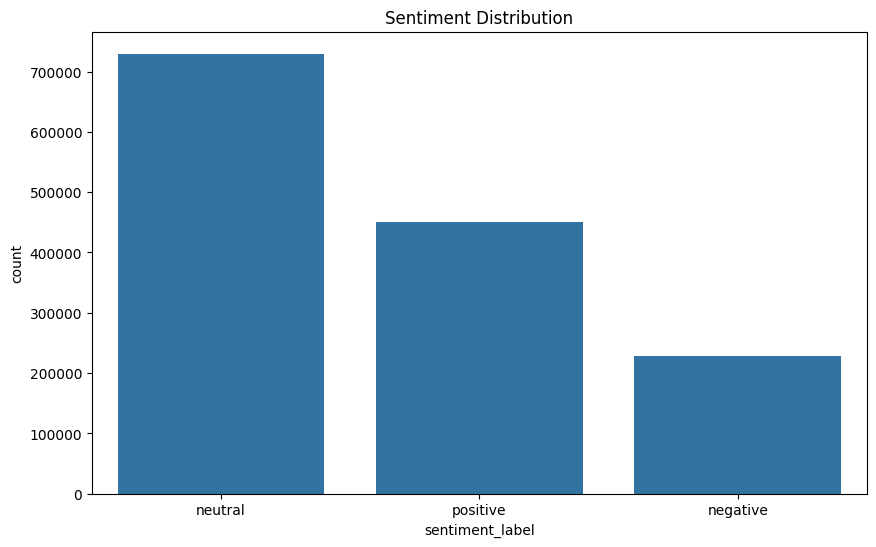

In [43]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_label', data=df)
plt.title('Sentiment Distribution')
plt.show()

### Dominant Topic Distribution


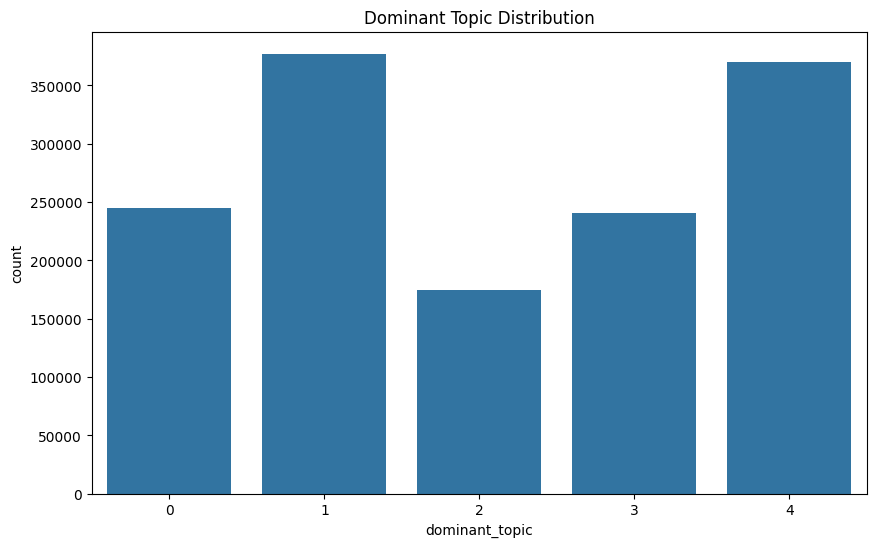

In [44]:
plt.figure(figsize=(10, 6))
sns.countplot(x='dominant_topic', data=df)
plt.title('Dominant Topic Distribution')
plt.show()